In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:

# You can use the parse_dates and dayfirst arguments of pd.read_csv, see: the docs for read_csv()

# df = pd.read_csv('myfile.csv', parse_dates=['Date'], dayfirst=True)

In [2]:
df = pd.read_csv(r"Datos Completos\Octubre-Abril.csv", sep= "\t", parse_dates=["PoC AB12"], dayfirst=True)
df.columns = ["Date","Pax"]
df = df.iloc[4:,:].reset_index(False)
df = df.drop("index", axis=1)
df

,Date,Pax
0,01-04-2024 00:01:38,0
1,01-04-2024 00:02:34,0
2,01-04-2024 00:03:39,0
3,01-04-2024 00:04:34,0
4,01-04-2024 00:05:35,0
...,...,...
210481,31-10-2023 15:09:39,0
210482,31-10-2023 15:10:39,0
210483,31-10-2023 15:11:39,0
210484,31-10-2023 15:12:39,0


In [ ]:
# df.info()

In [ ]:
# df.describe()

In [ ]:
# df["Date"].dtype

In [3]:
df["Date"] = pd.to_datetime(df["Date"],  format="%d-%m-%Y %H:%M:%S")
df["Pax"] = pd.to_numeric(df["Pax"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210486 entries, 0 to 210485
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    210486 non-null  datetime64[ns]
 1   Pax     210486 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.2 MB


In [4]:
df

,Date,Pax
0,2024-04-01 00:01:38,0
1,2024-04-01 00:02:34,0
2,2024-04-01 00:03:39,0
3,2024-04-01 00:04:34,0
4,2024-04-01 00:05:35,0
...,...,...
210481,2023-10-31 15:09:39,0
210482,2023-10-31 15:10:39,0
210483,2023-10-31 15:11:39,0
210484,2023-10-31 15:12:39,0


In [5]:

df["Hour"] = df["Date"].dt.hour
df["Minute"] = df["Date"].dt.minute
# df['5min'] = df['Date'].dt.round('5min')
df["Day"] = df["Date"].dt.day
df["Day_name"] = df["Date"].dt.day_name()
df["month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

df
# df["Fecha"] = pd.to_datetime(df["Fecha"],  format="%d-%m-%Y %H:%M:%S")




,Date,Pax,Hour,Minute,Day,Day_name,month,Year
0,2024-04-01 00:01:38,0,0,1,1,Monday,4,2024
1,2024-04-01 00:02:34,0,0,2,1,Monday,4,2024
2,2024-04-01 00:03:39,0,0,3,1,Monday,4,2024
3,2024-04-01 00:04:34,0,0,4,1,Monday,4,2024
4,2024-04-01 00:05:35,0,0,5,1,Monday,4,2024
...,...,...,...,...,...,...,...,...
210481,2023-10-31 15:09:39,0,15,9,31,Tuesday,10,2023
210482,2023-10-31 15:10:39,0,15,10,31,Tuesday,10,2023
210483,2023-10-31 15:11:39,0,15,11,31,Tuesday,10,2023
210484,2023-10-31 15:12:39,0,15,12,31,Tuesday,10,2023


In [ ]:
df["max_pax"]

In [ ]:
df_max_personas = df.groupby('5min')['Pax'].max().reset_index()
df_max_personas 

In [ ]:
df_max_personas["Hour"] = df_max_personas["5min"].dt.hour
df_max_personas["Minute"] = df_max_personas["5min"].dt.minute
df_max_personas['5min'] = df_max_personas['5min'].dt.round('5min')
df_max_personas["Day"] = df_max_personas["5min"].dt.day
# df["Day_name"] = df["Date"].dt.day_name()
df_max_personas["month"] = df_max_personas["5min"].dt.month
df_max_personas["Year"] = df_max_personas["5min"].dt.year


In [12]:
""" al parecer los meses de Marzo y Octubre no tienen registrado el día 1. Lo mismo ocurre con otros varios dias en varios meses"""
df[df["Day"]==1].loc[:,"month"].unique()

array([ 4,  2,  1, 12, 11])

In [15]:
"""" Con esto cancelamos las detecciones fuera del horario laboral"""

df.loc[df['Hour'] == 0, 'Pax'] = 0
df.loc[df['Hour'] == 1, 'Pax'] = 0
df.loc[df['Hour'] == 2, 'Pax'] = 0
df.loc[df['Hour'] == 3, 'Pax'] = 0
df.loc[df['Hour'] == 4, 'Pax'] = 0
df.loc[df['Hour'] == 5, 'Pax'] = 0
df.loc[df['Hour'] == 6, 'Pax'] = 0
df.loc[df['Hour'] == 20, 'Pax'] = 0
df.loc[df['Hour'] == 21, 'Pax'] = 0
df.loc[df['Hour'] == 22, 'Pax'] = 0
df.loc[df['Hour'] == 23, 'Pax'] = 0

In [8]:
""" separación de datos por meses"""

df4 = df.loc[df.loc[:,"month"]==4]
df3 = df.loc[df.loc[:,"month"]==3]
df2 = df.loc[df.loc[:,"month"]==2]
df1 = df.loc[df.loc[:,"month"]==1]
df12 = df.loc[df.loc[:,"month"]==12]
df11 = df.loc[df.loc[:,"month"]==11]
df10 = df.loc[df.loc[:,"month"]==10]

<Axes: >

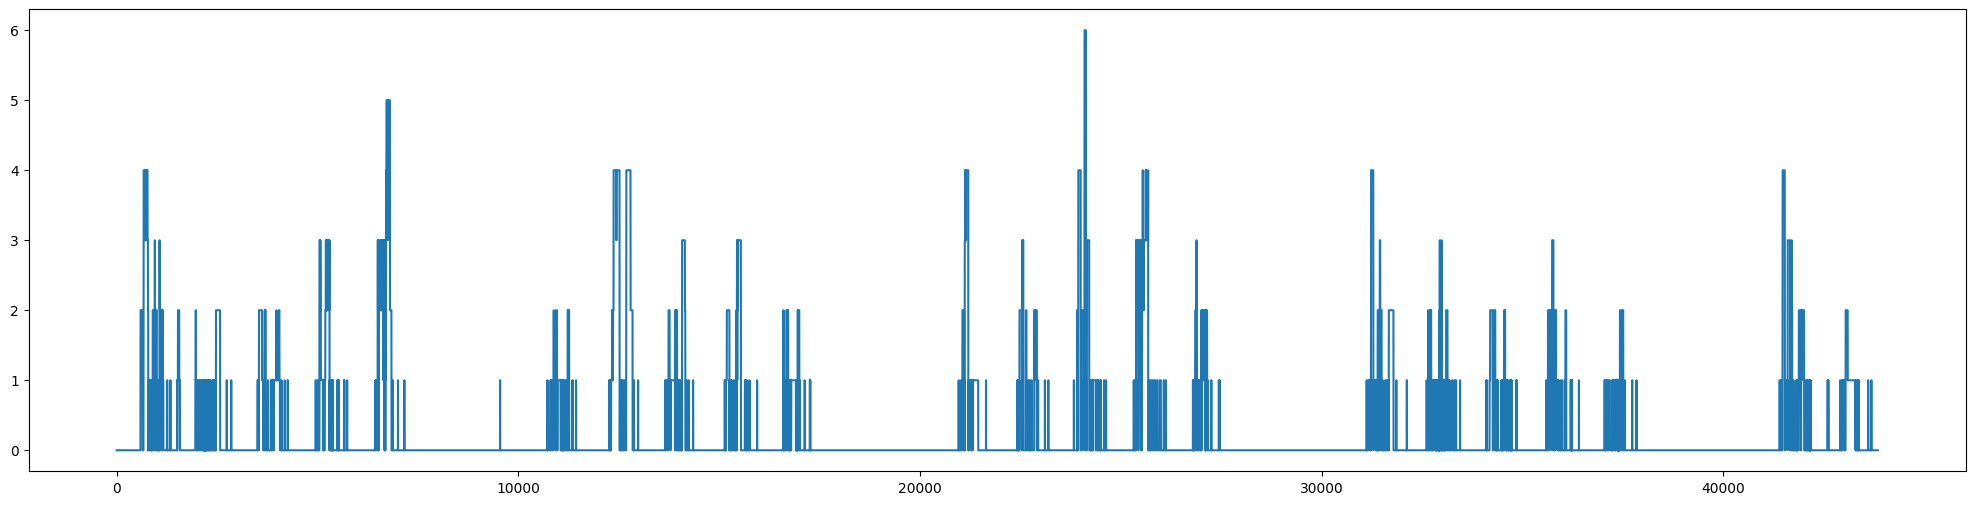

In [9]:
df4.loc[:,"Pax"].plot(figsize=(25,6))

In [25]:
df4

,Date,Pax,Hour,Minute,Day,Day_name,month,Year
0,2024-04-01 00:01:38,0,0,1,1,Monday,4,2024
1,2024-04-01 00:02:34,0,0,2,1,Monday,4,2024
2,2024-04-01 00:03:39,0,0,3,1,Monday,4,2024
3,2024-04-01 00:04:34,0,0,4,1,Monday,4,2024
4,2024-04-01 00:05:35,0,0,5,1,Monday,4,2024
...,...,...,...,...,...,...,...,...
43848,2024-04-30 23:54:13,0,23,54,30,Tuesday,4,2024
43849,2024-04-30 23:55:10,0,23,55,30,Tuesday,4,2024
43850,2024-04-30 23:56:13,0,23,56,30,Tuesday,4,2024
43851,2024-04-30 23:57:10,0,23,57,30,Tuesday,4,2024


In [23]:
df4[df4["Day_name"]=="Monday"].loc[:,"Pax"].value_counts()

Pax
0    5444
1     909
2     602
4     278
3     109
Name: count, dtype: int64

In [24]:
df4[df4["Day_name"]=="Wednesday"].loc[:,"Pax"].value_counts()

Pax
0    4477
1     781
2     388
3     130
4      60
6      37
5       1
Name: count, dtype: int64

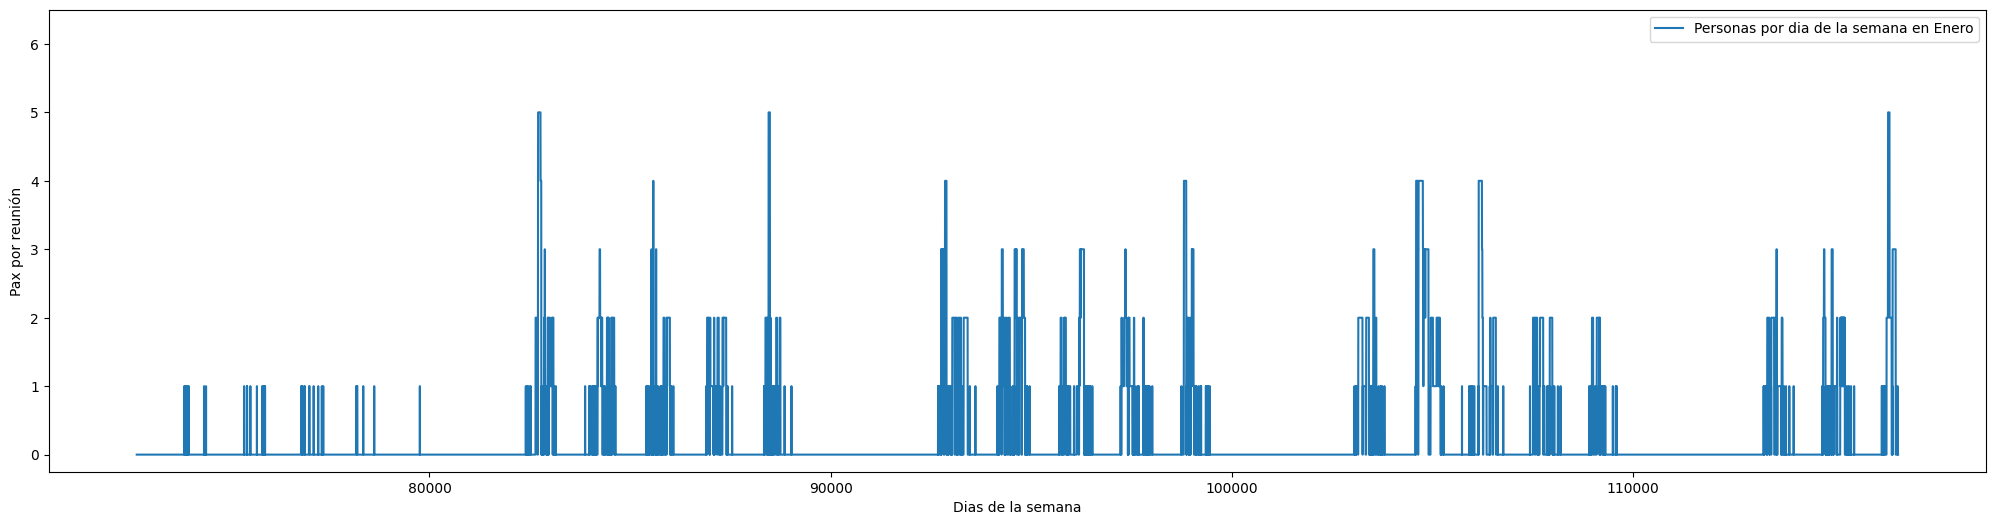

In [10]:
plt.figure(figsize=(25, 6))
# Trazar los valores reales (y_train + y_test)
plt.plot(df1.loc[:,"Pax"], label='Personas por dia de la semana en Enero')
# Trazar los valores predichos (y_test + predicciones)
# plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100], color='red', label='Valores predichos')

# Agregar la leyenda
plt.legend()
plt.xlabel("Dias de la semana")
plt.ylabel("Pax por reunión")
plt.ylim(top = 6.5)
# plt.xticks(ticks=range(len(df1["Day_name"])), labels=df1["Day_name"], rotation=45)
# Mostrar el gráfico
plt.show()

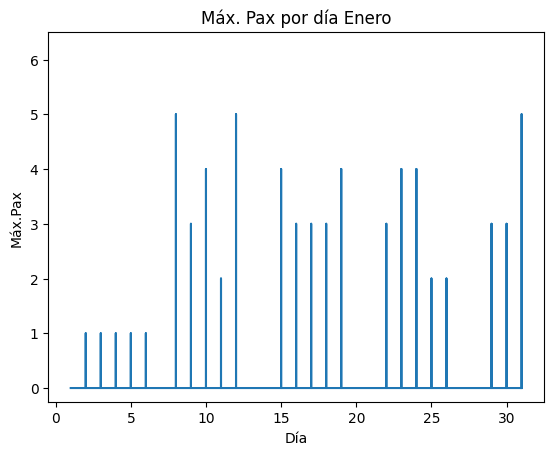

In [70]:
X = df1['Day']
Y = df1['Pax']

# Crear una gráfica de dispersión
plt.plot(X, Y)
plt.xlabel('Día')
plt.ylabel('Máx.Pax')
plt.ylim(top=6.5)
plt.title('Máx. Pax por día Enero')
plt.show()

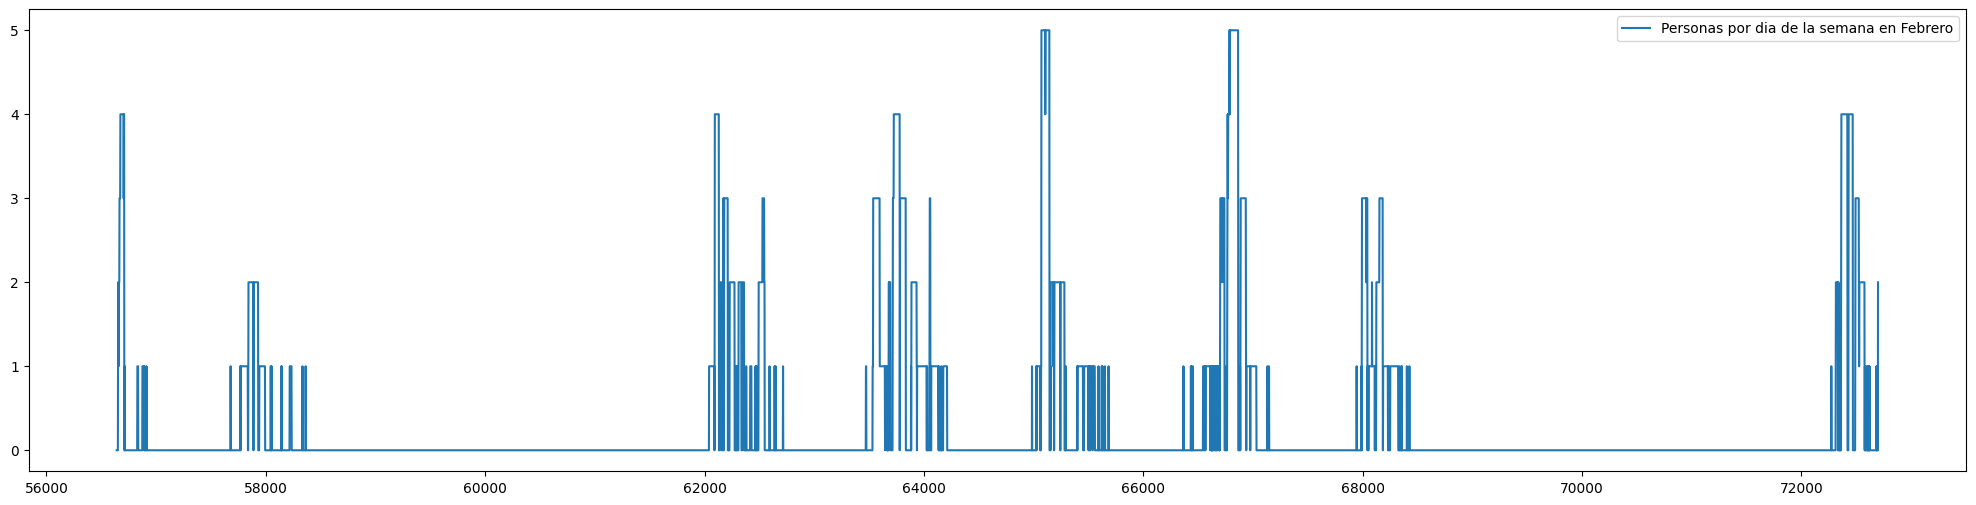

In [31]:
plt.figure(figsize=(25, 6))
# Trazar los valores reales (y_train + y_test)
plt.plot(df2.loc[:,"Pax"], label='Personas por dia de la semana en Febrero')
# Trazar los valores predichos (y_test + predicciones)
# plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100], color='red', label='Valores predichos')

# Agregar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

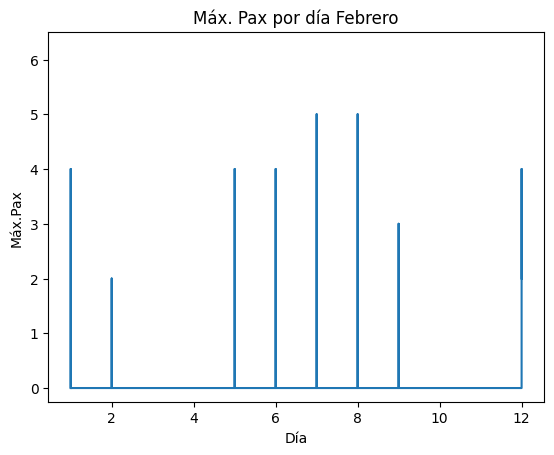

In [69]:
X = df2['Day']
Y = df2['Pax']

# Crear una gráfica de dispersión
plt.plot(X, Y)
plt.xlabel('Día')
plt.ylabel('Máx.Pax')
plt.ylim(top=6.5)
plt.title('Máx. Pax por día Febrero')
plt.show()

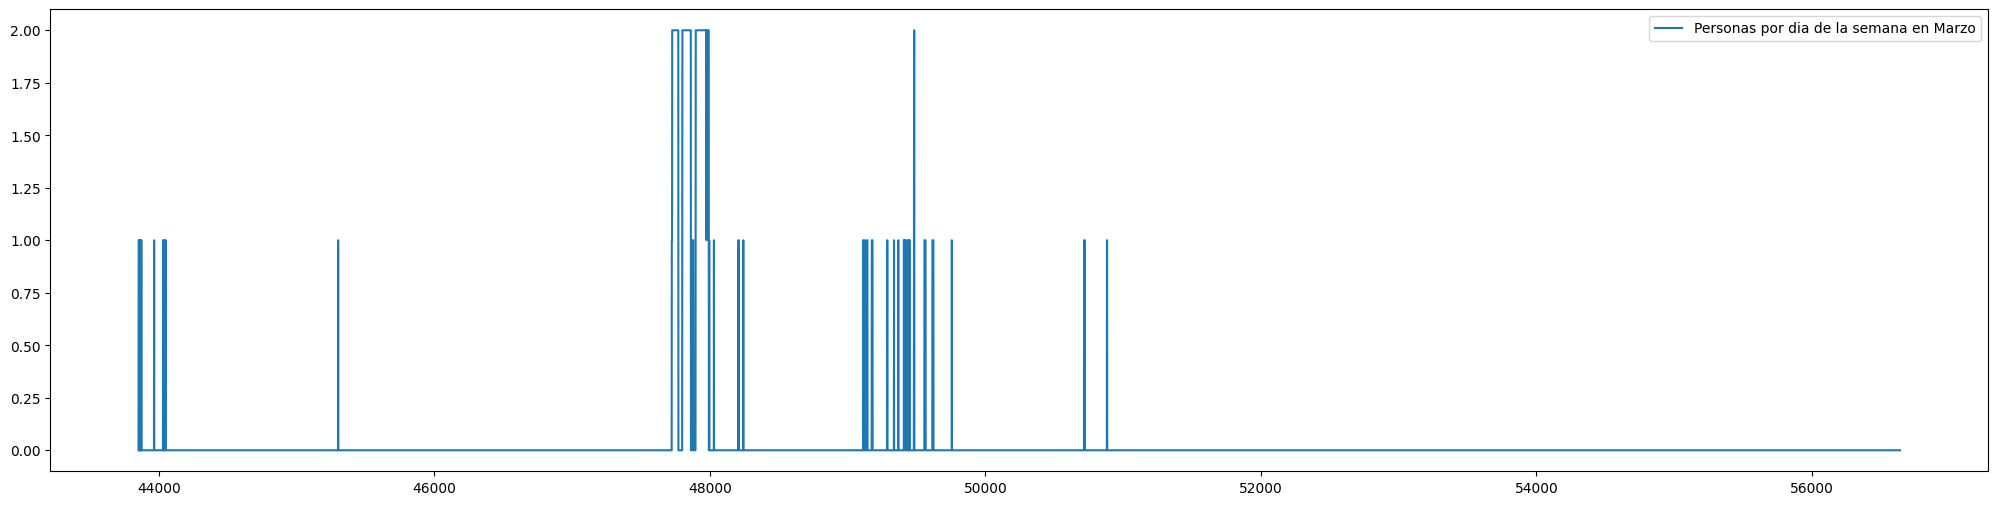

In [32]:
plt.figure(figsize=(25, 6))
# Trazar los valores reales (y_train + y_test)
plt.plot(df3.loc[:,"Pax"], label='Personas por dia de la semana en Marzo')
# Trazar los valores predichos (y_test + predicciones)
# plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100], color='red', label='Valores predichos')

# Agregar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

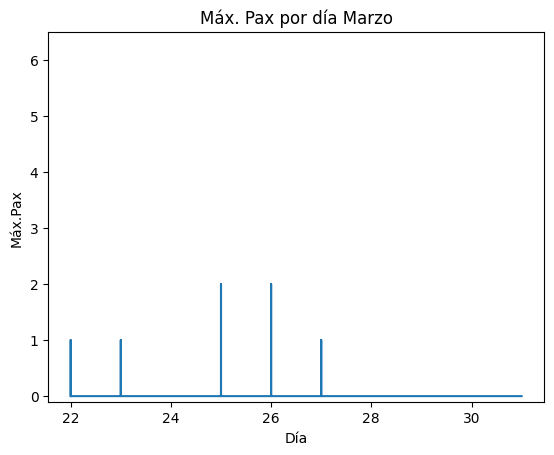

In [68]:
X = df3['Day']
Y = df3['Pax']

# Crear una gráfica de dispersión
plt.plot(X, Y)
plt.xlabel('Día')
plt.ylabel('Máx.Pax')
plt.ylim(top=6.5)
plt.title('Máx. Pax por día Marzo')
plt.show()

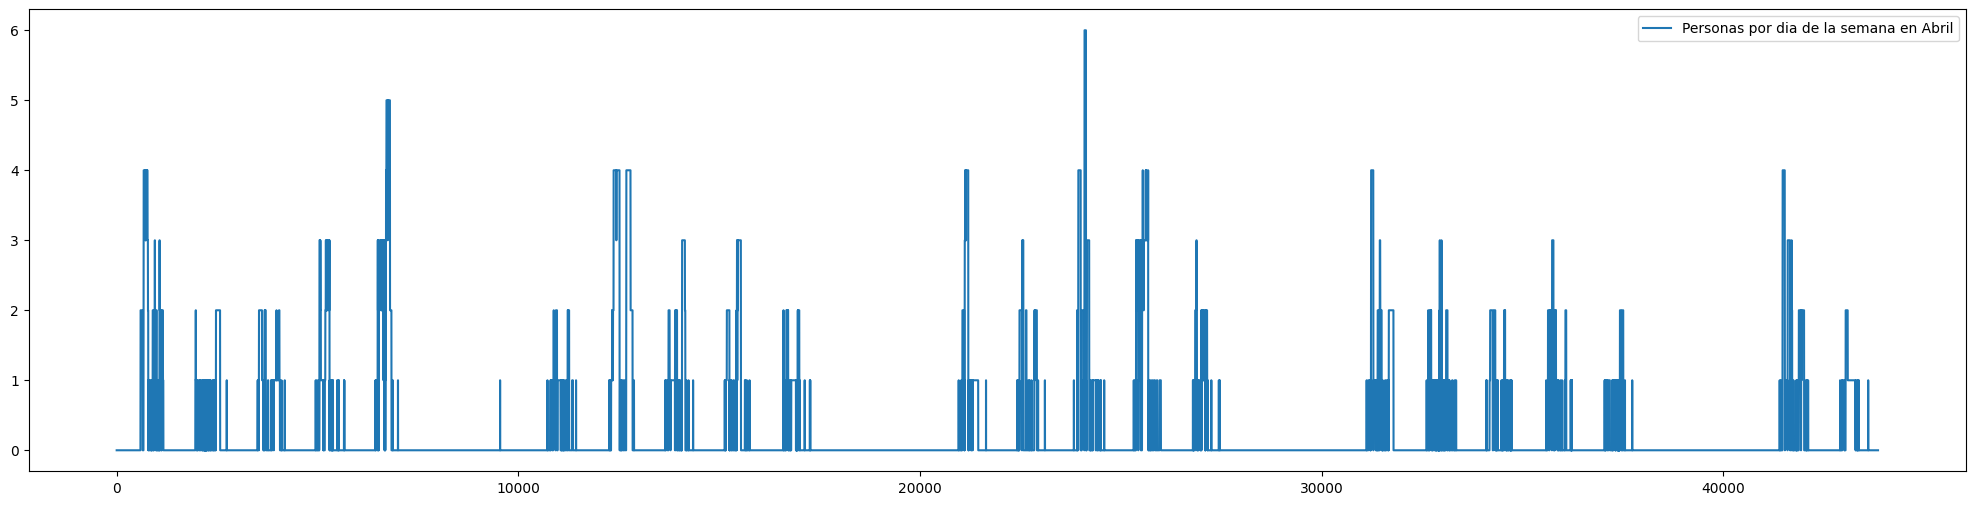

In [33]:
plt.figure(figsize=(25, 6))
# Trazar los valores reales (y_train + y_test)
plt.plot(df4.loc[:,"Pax"], label='Personas por dia de la semana en Abril')
# Trazar los valores predichos (y_test + predicciones)
# plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100], color='red', label='Valores predichos')

# Agregar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

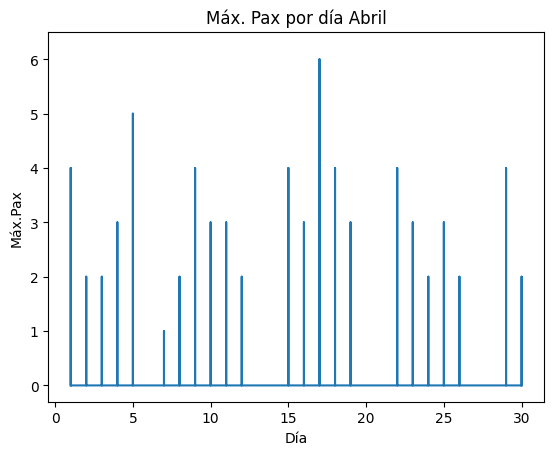

In [60]:
X = df4['Day']
Y = df4['Pax']

# Crear una gráfica de dispersión
plt.plot(X, Y)
plt.xlabel('Día')
plt.ylabel('Máx.Pax')
plt.ylim(top=6.5)
plt.title('Máx. Pax por día Abril')
plt.show()

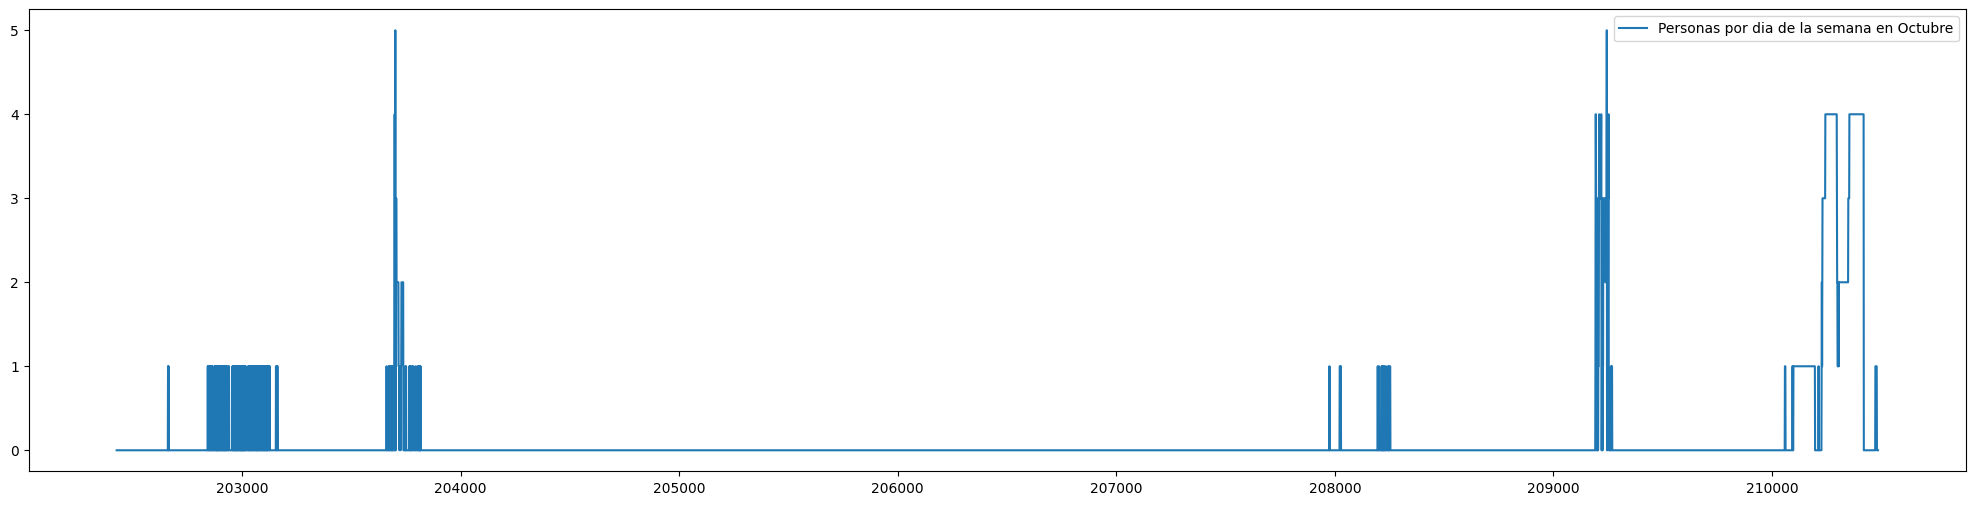

In [34]:
plt.figure(figsize=(25, 6))
# Trazar los valores reales (y_train + y_test)
plt.plot(df10.loc[:,"Pax"], label='Personas por dia de la semana en Octubre')
# Trazar los valores predichos (y_test + predicciones)
# plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100], color='red', label='Valores predichos')

# Agregar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

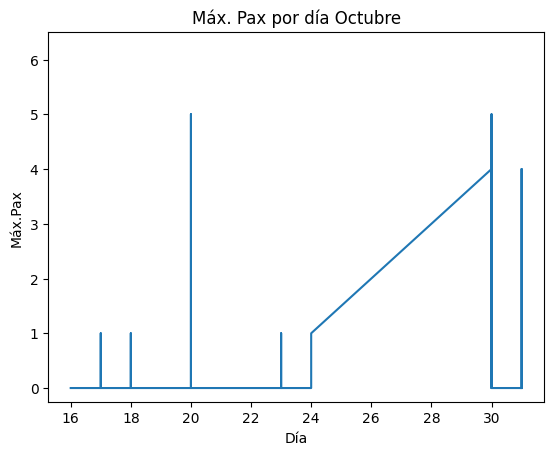

In [67]:
X = df10['Day']
Y = df10['Pax']

# Crear una gráfica de dispersión
plt.plot(X, Y)
plt.xlabel('Día')
plt.ylabel('Máx.Pax')
plt.ylim(top=6.5)
plt.title('Máx. Pax por día Octubre')
plt.show()

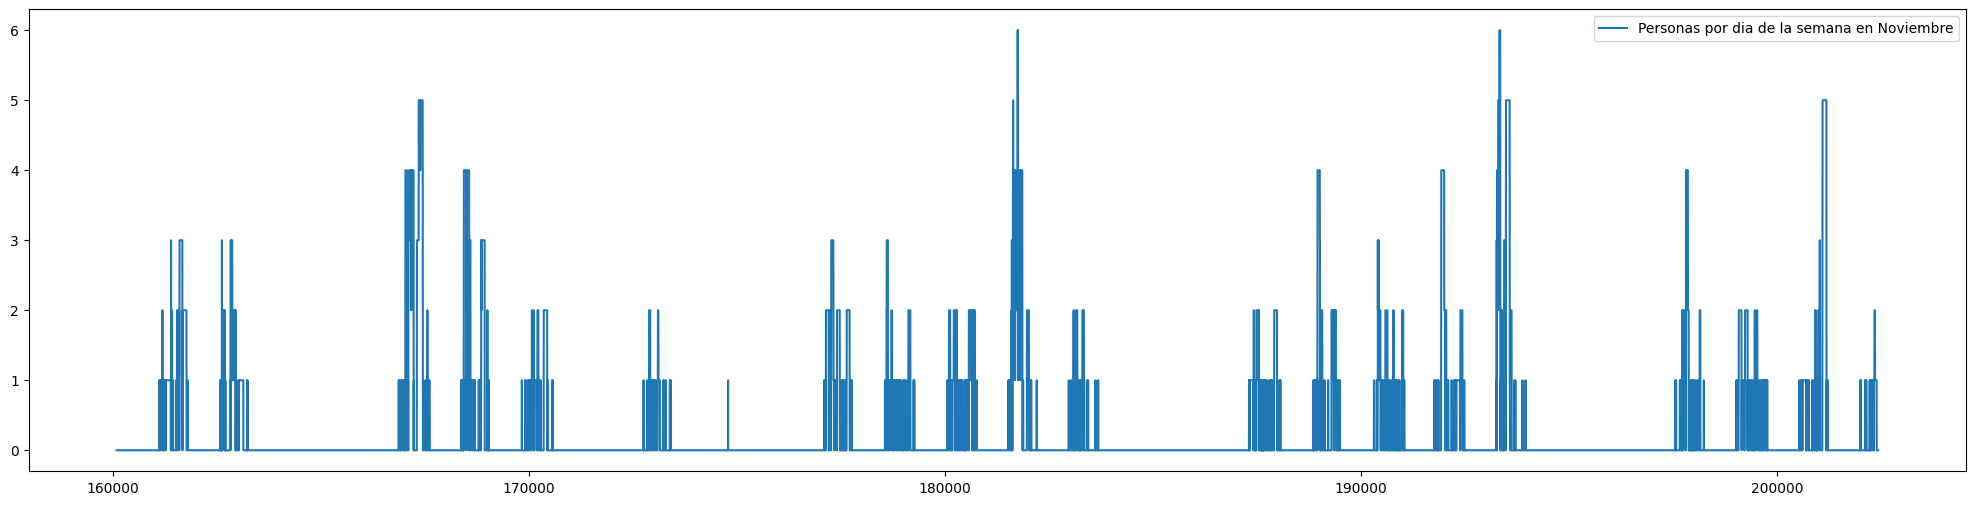

In [35]:
plt.figure(figsize=(25, 6))
# Trazar los valores reales (y_train + y_test)
plt.plot(df11.loc[:,"Pax"], label='Personas por dia de la semana en Noviembre')
# Trazar los valores predichos (y_test + predicciones)
# plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100], color='red', label='Valores predichos')

# Agregar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

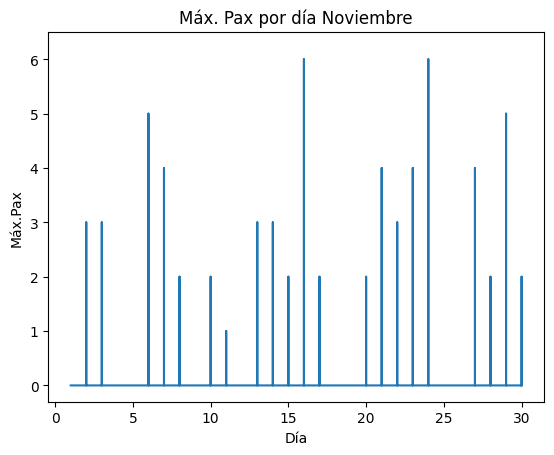

In [66]:
X = df11['Day']
Y = df11['Pax']

# Crear una gráfica de dispersión
plt.plot(X, Y)
plt.xlabel('Día')
plt.ylabel('Máx.Pax')
plt.ylim(top=6.5)
plt.title('Máx. Pax por día Noviembre')
plt.show()

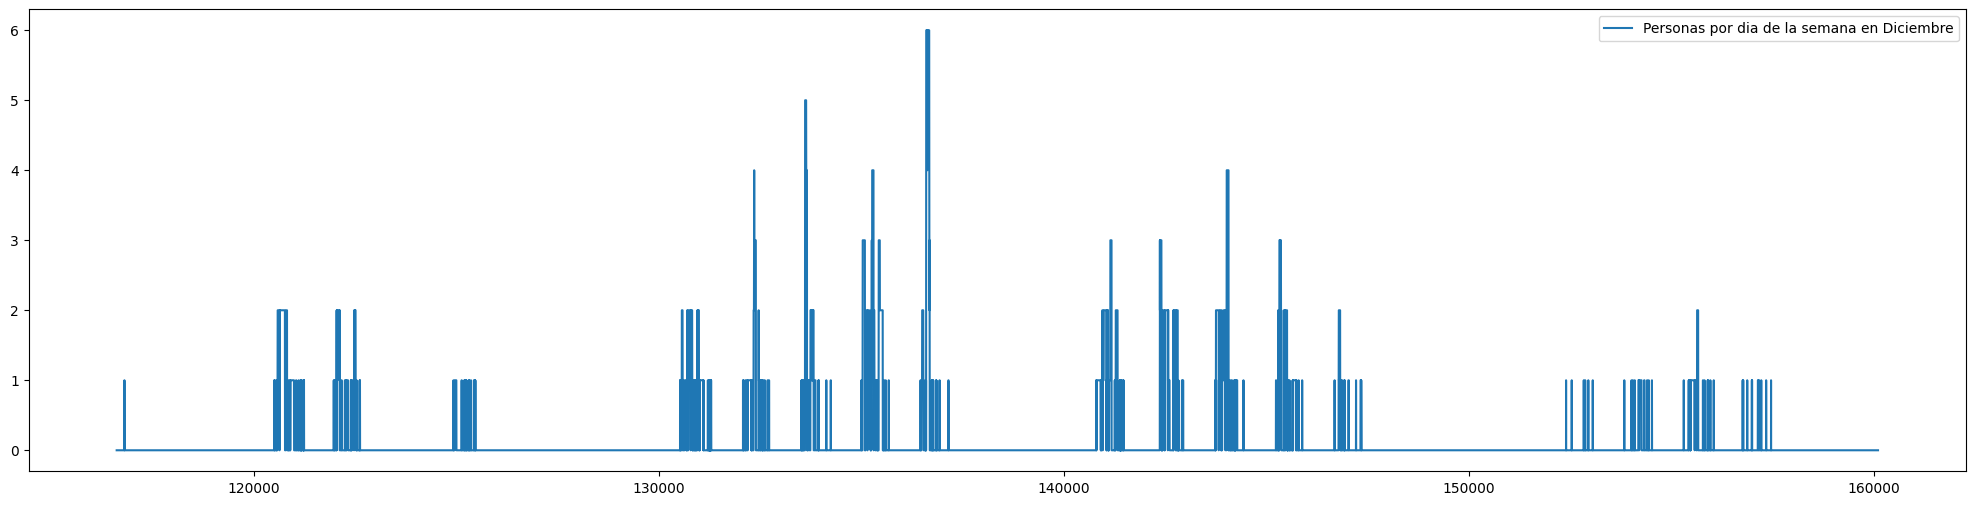

In [36]:
plt.figure(figsize=(25, 6))
# Trazar los valores reales (y_train + y_test)
plt.plot(df12.loc[:,"Pax"], label='Personas por dia de la semana en Diciembre')
# Trazar los valores predichos (y_test + predicciones)
# plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100], color='red', label='Valores predichos')

# Agregar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

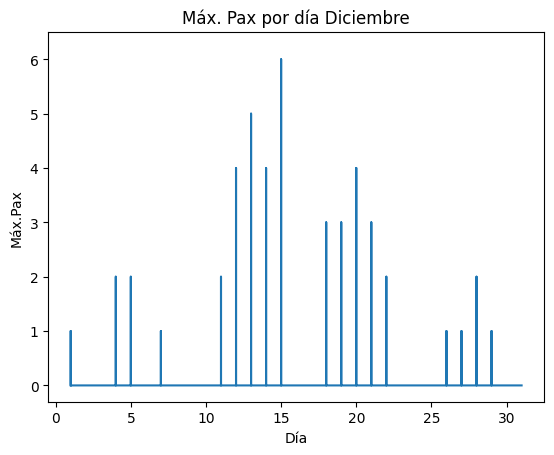

In [64]:
X = df12['Day']
Y = df12['Pax']

# Crear una gráfica de dispersión
plt.plot(X, Y)
plt.xlabel('Día')
plt.ylabel('Máx.Pax')
plt.ylim(top=6.5)
plt.title('Máx. Pax por día Diciembre')
plt.show()

In [ ]:
df_t = df.drop(["Date","5min"],axis=1)
df_t

In [ ]:
df_max_personas


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df_max_personas.drop(["5min","Pax"],axis=1),df_max_personas["Pax"],test_size=0.2,random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
xgb = XGBRegressor(max_depth=6,
                   cv = 10,
                   n_jobs = -1,
                   random_state = 0)
xgb.fit(X_train,y_train)

In [ ]:
predictions = xgb.predict(X_test)

In [ ]:
print("mean_squared_error:", mean_squared_error(y_test, predictions))
print("r2_score:", r2_score(y_test, predictions))

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(y_train.tolist()[0:100] + y_test.tolist()[0:100] )
plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100] ,color='red');

In [ ]:
plt.figure(figsize=(25, 6))
# Trazar los valores reales (y_train + y_test)
plt.plot(y_train.tolist()[0:100] + y_test.tolist()[0:100], label='Valores reales')
# Trazar los valores predichos (y_test + predicciones)
plt.plot(y_test.tolist()[0:100] + xgb.predict(X_test).astype(int).tolist()[0:100], color='red', label='Valores predichos')

# Agregar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
""" lo hemos hecho arriba ya, y tnemos todas las otras columnas también"""

# # Redondear la columna 'fecha_hora' al intervalo de 15 minutos
# df['5min'] = df['Date'].dt.round('5min')
# df.head()

In [ ]:
""" no es necesario ejecutarlo"""
# # Agrupar por 'fecha_hora_rounded' y obtener el máximo de 'personas_presentes'
# df_max_personas = df.groupby('5min')['Pax'].max().reset_index()
# df_max_personas 

In [ ]:
""" gráfico mostrando nº personas por cada dia de la semana (en bloques de 15 min)"""
df.groupby("5min")[["Pax"]].max().plot(figsize=(25,6))

In [ ]:
""" ejemplo que hemos utilizado para subdividir en bloques de 5 min"""

# Suponiendo que tu dataframe se llama df y las columnas son 'fecha_hora' y 'personas_presentes'
# Asegúrate de que 'fecha_hora' sea de tipo datetime

# # Convertir 'fecha_hora' a tipo datetime si no lo es
# df['fecha_hora'] = pd.to_datetime(df['fecha_hora'])

# Redondear la columna 'fecha_hora' al intervalo de 15 minutos
df['15min'] = df['Date'].dt.round('15min')

# Agrupar por 'fecha_hora_rounded' y obtener el máximo de 'personas_presentes'
df_max_personas = df.groupby('15min')['Pax'].max().reset_index()

# Unir el dataframe original con los máximos de personas presentes
df = df.merge(df_max_personas, on='fecha_hora_rounded', suffixes=('', '_max'))

# Renombrar la columna de máximos
df.rename(columns={'personas_presentes_max': 'max_personas_15min'}, inplace=True)

# Ahora en 'max_personas_15min' tendrás los valores máximos de personas presentes en intervalos de 15 minutos

In [ ]:
# df = df.groupby(["Hour","month","Day","Year"])[["Pax"]].max().reset_index()
# df

In [ ]:
# df.info()

In [ ]:
# """ eliminamos cualquier detección fuerea de las horas laborales de la oficina"""

# df.loc[df['Hour'] == 0, 'Pax'] = 0
# df.loc[df['Hour'] == 1, 'Pax'] = 0
# df.loc[df['Hour'] == 2, 'Pax'] = 0
# df.loc[df['Hour'] == 3, 'Pax'] = 0
# df.loc[df['Hour'] == 4, 'Pax'] = 0
# df.loc[df['Hour'] == 5, 'Pax'] = 0
# df.loc[df['Hour'] == 6, 'Pax'] = 0
# df.loc[df['Hour'] == 20, 'Pax'] = 0
# df.loc[df['Hour'] == 21, 'Pax'] = 0
# df.loc[df['Hour'] == 22, 'Pax'] = 0
# df.loc[df['Hour'] == 23, 'Pax'] = 0

# df


In [ ]:
# """ separación de datos por meses"""

# df4 = df.loc[df.loc[:,"month"]==4]
# df3 = df.loc[df.loc[:,"month"]==3]
# df2 = df.loc[df.loc[:,"month"]==2]
# df1 = df.loc[df.loc[:,"month"]==1]
# df12 = df.loc[df.loc[:,"month"]==12]
# df11 = df.loc[df.loc[:,"month"]==11]
# df10 = df.loc[df.loc[:,"month"]==10]


In [ ]:
# df41 = df4.drop("Pax", axis=1)
# df31 = df3.drop("Pax", axis=1)
# df21 = df2.drop("Pax", axis=1)
# df01 = df1.drop("Pax", axis=1)
# df121 = df12.drop("Pax", axis=1)
# df111 = df11.drop("Pax", axis=1)
# df101 = df10.drop("Pax", axis=1)


In [ ]:
# df41["Year","month","Day"] = pd.to_datetime(df41)
# df31["Year","month","Day"] = pd.to_datetime(df31)
# df21["Year","month","Day"] = pd.to_datetime(df21)
# df01["Year","month","Day"] = pd.to_datetime(df01)
# df121["Year","month","Day"] = pd.to_datetime(df121)
# df111["Year","month","Day"] = pd.to_datetime(df111)
# df101["Year","month","Day"] = pd.to_datetime(df101)

In [ ]:
# df4["Fecha"] = df41.iloc[:,4]
# df3["Fecha"] = df31.iloc[:,4]
# df2["Fecha"] = df21.iloc[:,4]
# df1["Fecha"] = df01.iloc[:,4]
# df12["Fecha"] = df121.iloc[:,4]
# df11["Fecha"] = df111.iloc[:,4]
# df10["Fecha"] = df101.iloc[:,4]

In [ ]:
# df11


In [ ]:
# df4["Pax"] = df["Pax"]*10

In [ ]:
# df4.loc[:,"Pax"]

In [ ]:
# """ gráfico mostrando nº personas (multiplicado por 10 para mejor visualización) por cada dia de la semana (en horas)"""
# df4.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

In [ ]:
# df3.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

In [ ]:
# df2.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

In [ ]:
# df1.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

In [ ]:
# df12.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

In [ ]:
# df11.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

In [ ]:
# df10.groupby("Fecha")[["Pax"]].max().plot(figsize=(25,6))

In [ ]:
# """ muestra de personas por hora detectadas en 1 dia (1 de Abril)"""
# df41 = df4.loc[df4.loc[:,"Day"]==1]
# df41.groupby("Hour")[["Pax"]].max().reset_index()
# # df41

In [ ]:
df41.groupby("Hour")[["Pax"]].max().reset_index(drop = True).plot(figsize=(15,6))

In [ ]:
plot_acf(df41.groupby("Hour")[["Pax"]].max().reset_index(drop = True))

In [ ]:
df4

In [ ]:
df41.groupby("Hour")[["Nº Personas"]].max().reset_index(drop = True).plot(figsize=(15,6))

In [ ]:
df41_21 = df41.loc[df41.loc[:,"Hour"]==21]
df41_21.loc[df41_21.loc[:,"Nº Personas"]!=0]

In [ ]:
df41_20 = df41.loc[df41.loc[:,"Hour"]==20]
df41_20.loc[df41_20.loc[:,"Nº Personas"]!=0]

In [ ]:
# df41_21.loc[df41_21.loc[1340:1350, "Nº Personas"].index]

In [ ]:
# df41_20.loc[df41_20.loc[1260:1270, "Nº Personas"].index]

In [ ]:
df42 =  df4.loc[df4.loc[:,"Day_month"]==2]
df42.groupby("Hour")[["Nº Personas"]].max().reset_index()
df42_0 = df42.loc[df42.loc[:,"Hour"]==0]
df42_0.loc[df42_0.loc[:,"Nº Personas"]!=0]


In [ ]:
df42_0 = df42.loc[df42.loc[:,"Hour"]==1]
df42_0.loc[df42_0.loc[:,"Nº Personas"]!=0]

In [ ]:
df44 =  df4.loc[df4.loc[:,"Day_month"]==1]
df44.groupby("Hour")[["Nº Personas"]].max().reset_index()
df44_0 = df44.loc[df44.loc[:,"Hour"]==20]
df44_0.loc[df44_0.loc[:,"Nº Personas"]!=0]

In [ ]:
abril = []
for i in np.arange(1,31):
    
    abril.append(df4.loc[df4.loc[:,"Day_month"]==i].groupby("Hour")[["Nº Personas"]].max().reset_index())


In [ ]:
abril

In [ ]:
len(abril)

In [ ]:
for idx,i  in enumerate(abril):
    print(f"Dia {idx+1}",abril[idx])

In [ ]:
df4.loc[:,]

In [ ]:
sns.pairplot(df4)


In [ ]:
plt.plot(df3["Day"], df3["Nº Personas"])


In [ ]:
plt.plot(df2["Day"], df2["Nº Personas"])


In [ ]:
plt.plot(df1["Day"], df1["Nº Personas"])


In [ ]:
plt.plot(df12["Day"], df12["Nº Personas"])


In [ ]:
plt.plot(df11["Day"], df11["Nº Personas"])


In [ ]:
plt.plot(df10["Day"], df10["Nº Personas"])

In [ ]:
""" Nº de personas máximas por hora durante el mes"""
df4p = df4.loc[df4.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df3p = df3.loc[df3.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df2p = df2.loc[df2.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df1p = df1.loc[df1.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df12p = df12.loc[df12.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df11p = df11.loc[df11.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()
df10p = df10.loc[df10.loc[:,"Nº Personas"]!=0].groupby("Hour")[["Nº Personas"]].max().reset_index()


In [ ]:
df4p

In [ ]:

df = df4p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df4p["Hour"], y=df4p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Abril')

# Mostrar la gráfica
plt.show()


In [ ]:
DFS = [df4,df3,df2,df1,df12,df11,df10]

In [ ]:
# for idx, i in enumerate(DFS[0]):
#     df = DFS[idx]

# # Crear la gráfica de barras
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=df["Hour"], y=df["Nº Personas"], data=df, palette='viridis')

#     # Añadir títulos y etiquetas
#     plt.xlabel('Hora')
#     plt.ylabel('Personas')
#     plt.title('Personas/Hora')

#     # Mostrar la gráfica
#     plt.show()

In [ ]:
df = df3p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df3p["Hour"], y=df3p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Marzo')

# Mostrar la gráfica
plt.show()

In [ ]:

df = df2p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df2p["Hour"], y=df2p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Febrero')

# Mostrar la gráfica
plt.show()


In [ ]:

df = df1p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df1p["Hour"], y=df1p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Enero')

# Mostrar la gráfica
plt.show()


In [ ]:

df = df12p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df12p["Hour"], y=df12p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Diciembre')

# Mostrar la gráfica
plt.show()


In [ ]:

df = df11p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df11p["Hour"], y=df11p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Noviembre')

# Mostrar la gráfica
plt.show()


In [ ]:

df = df10p

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df10p["Hour"], y=df10p["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas/Hora Octubre')

# Mostrar la gráfica
plt.show()


In [ ]:
df4_m = df4.loc[df4.loc[:,"Day"]=="Monday"].groupby("Hour")[["Nº Personas"]].max().reset_index()
df4_m

In [ ]:

df = df4_m

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=df4_m["Hour"], y=df4_m["Nº Personas"], data=df, palette='viridis')

# Añadir títulos y etiquetas
plt.xlabel('Hora')
plt.ylabel('Personas')
plt.title('Personas max/Hora Abril Lunes')

# Mostrar la gráfica
plt.show()